# Vehicle Detection and Tracking
Writing a software pipeline to detect and track vehicles in a video from a front-facing camera on a car

The Goals of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images, binned it with a color transform, to train Linear SVM classifier
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Design, train and validate a model that perform vehicle detection on images
* Use the model to detect vehicles on video frames
* Summarize the results with a written report

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pickle
import glob
import cv2
import os

from skimage.feature import hog
from skimage import color, exposure

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as trainTestSplit

from scipy.ndimage.measurements import label
from scipy.ndimage.morphology import generate_binary_structure


### Load The Data

For this project I needed labeled data for vehicle and non-vehicle examples to train my classifier. I took the dataset from the following sources:

* GTI vehicle image database
* KITTI vision benchmark suite
* Udacity vehicle dataset

I added a randomized train-test split on the data with 20% for test, and then ran it again with 20% for the validation set. Additionally, I used cv2.flip method to double the training set when feeding the model.

In [2]:
dataFile = 'sample_data_file_names.p'

if not os.path.isfile(dataFile):
    path = "/home/carnd/vehicle_detection/data/"
    cars_udacity = glob.glob(path + 'Udacity/vehicles/*/*.jpeg')
    #print(len(cars_udacity))
    not_cars_udacity = glob.glob(path + 'Udacity/non-vehicles/*/*.jpeg')
    #print(len(not_cars_udacity))
    cars_gti = glob.glob(path + 'GTI/vehicles/*/*.png')
    #print(len(cars_gti))
    not_cars_gti = glob.glob(path + 'GTI/non-vehicles/*/*.png')
    #print(len(not_cars_gti))
    cars_kitti = glob.glob(path + 'KITTI/vehicles/*/*.png')
    #print(len(cars_kitti))
    not_cars_kitti = glob.glob(path + 'KITTI/non-vehicles/*/*.png')
    #print(len(not_cars_kitti))
    
    image_samples = cars_udacity + cars_gti + cars_kitti + not_cars_udacity + not_cars_gti + not_cars_kitti
    y = np.concatenate((np.ones(len(cars_udacity)),np.ones(len(cars_gti)),np.ones(len(cars_kitti)),
                       np.zeros(len(not_cars_udacity)),np.zeros(len(not_cars_gti)),np.zeros(len(not_cars_kitti))))

    imageSamplesFiles, y = shuffle(image_samples, y)
    X_train, X_test, y_train, y_test = trainTestSplit(imageSamplesFiles, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = trainTestSplit(X_train, y_train, test_size=0.2, random_state=42)

    data = {'X_train': X_train, 'X_test': X_test, 'X_valid': X_valid, 'y_train': y_train, 'y_test': y_test, 'y_valid': y_valid}
    pickle.dump(data, open(dataFile, 'wb'))

with open(dataFile, mode='rb') as f:
    data = pickle.load(f)
    X_train = data['X_train']
    X_test = data['X_test']
    X_valid = data['X_valid']
    y_train = data['y_train']
    y_test = data['y_test']
    y_valid = data['y_valid']

train_samples = [(X_train[i], y_train[i]) for i in range(len(X_train))] 
test_samples = [(X_test[i], y_test[i]) for i in range(len(X_test))] 
validation_samples = [(X_valid[i], y_valid[i]) for i in range(len(X_valid))] 


### Dataset Summary & Exploration


Number of training examples = 26566
Number of validation examples = 6642
Number of testing examples = 8304



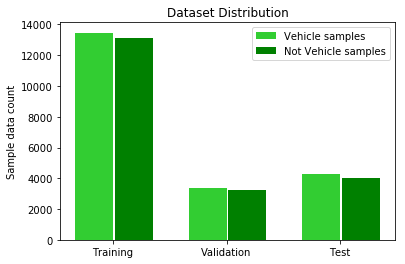

In [13]:

# Number of training examples
n_train = format(len(X_train))

# Number of validation examples
n_validation = format(len(X_valid))

# Number of testing examples
n_test = format(len(X_test))

print()
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)

train_car_samples= len([x for x in y_train if x == 1])
test_car_samples= len([x for x in y_test if x == 1])
valid_car_samples= len([x for x in y_valid if x == 1])

indices = range(0, 3)
width = np.min(np.diff(indices))/3
fig, ax = plt.subplots()
ax.bar(np.arange(3), (train_car_samples,valid_car_samples,test_car_samples), width, color='limegreen',label='Vehicle samples')
ax.bar(np.arange(3)+ 0.35, (int(n_train)-train_car_samples,int(n_validation)-valid_car_samples,int(n_test)-test_car_samples), width, color='green',label='Not Vehicle samples')
ax.set_ylabel('Sample data count')
ax.set_title('Dataset Distribution')
ax.set_xticks(np.arange(3) + width / 2)
ax.set_xticklabels(('Training', 'Validation', 'Test'))
ax.legend()
plt.show()

In [3]:
img_input_shape=(720, 1280, 3)
height_of_interest = (400, 700)
image_interest = (height_of_interest[1] - height_of_interest[0], img_input_shape[1], img_input_shape[2])
print("Region of interest for image frame:", image_interest)
print("Sample image shape:", (64, 64))

Region of interest for image frame: (300, 1280, 3)
Sample image shape: (64, 64)


## Model Architecture

My model consisted of the following layers:


| Layer | Component    	|     Output	 	|
|:----------------:|:------------:|:------------:|
| Lambda | Normalization and mean zero | (None, 300, 1280, 3) | 
| Convolution | filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu' | (None, 300, 1280, 16) | 
| Dropout	| rate=0.5 | (None, 300, 1280, 16)) | 
| Convolution |	filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'	|(None, 300, 1280, 32) | 
| Dropout	| rate=0.5 | (None, 300, 1280, 32) | 
| Convolution |filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'	| (None, 300, 1280, 64) | 
| Dropout	| rate=0.5 | (None, 300, 1280, 64) | 
| Max Pooling	| pool_size=(8, 8), padding='valid' | (None, 37, 160, 64) | 
| Dropout	| rate=0.5 | (None, 37, 160, 64) | 
| Convolution - Output	| filters=1, kernel_size=(8, 8), strides=(1, 1), padding='valid', activation='sigmoid' | (None, 30, 153, 1) | 

The network consists of a convolution neural network starting with normalization layer, followed by 3 convolution layers with kernel of 3x3 and 1 Max pool layer pool size of 8X8. filter sizes and depths between 16 and 64, followed by Dropout layers between them.

The model uses RELU activation on the layers to introduce nonlinearity, and the data is normalized in the model using a Keras lambda layer.

At the end of the model I have 1 convolution layer as the single output node for the prediction - Vehicle or not 

In [2]:
from keras.layers import Conv2D, Flatten, Lambda, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential

def generate_model(input_shape=(64, 64, 3)):
    dropout = 0.5
    model = Sequential()
    #normalization and mean zero - centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x / 255., input_shape=input_shape, output_shape=input_shape))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Dropout(dropout))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=1, kernel_size=(8, 8), activation="sigmoid"))
    return model

Using TensorFlow backend.


**Using Generator**

The dataset contains thousands of images (for vehicles and not-vehicles) and each image contains 12,288 pixels (64X64X3).
When the model is running on all of the dataset images we need a huge memory for the network training. 
I used Generator, enables to train the model by producing batches with data processing in real time, only when the model need it.

In [5]:
import cv2
import numpy as np
import random
from sklearn.utils import shuffle

def generator(samples, batch_size=32, is_training=False):
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images, classification = [], []
            X_train, y_train = [], []
            
            for batch_sample in batch_samples:
                fileName = batch_sample[0]
                image = cv2.imread(fileName)
                
                # Adding the original images, flipping them and append to the dataset
                images.append(image)
                classification.append(batch_sample[1])
                
                if (is_training):
                    images.append(cv2.flip(image, 1))
                    classification.append(batch_sample[1])
                 
            X_train = np.array(images)
            y_train = np.expand_dims(classification, axis=1)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
batch_size = 32
train_generator = generator(train_samples, batch_size, is_training=True)
validation_generator = generator(validation_samples, batch_size)
test_generator = generator(test_samples, batch_size)

The model was written with Keras over Tensorflow. I used the 'adam' optimizer, so the learning rate was not tuned manually. I used 5 epochs and batch size of 32 with attention to the memory usage. I used the ModelCheckpoint as the model callback, which saved the model after every epoch and also has the 'max' mode which takes the maximum of the monitored quantity, and saved the highest val_acc for the epochs.

In [9]:
from time import time
start_time = time()

epochs=5
batch_size = 32

model = generate_model()
model = Model(inputs=model.input, outputs=Flatten()(model.output))
#print(model.summary())
        
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_object = model.fit_generator(train_generator, steps_per_epoch= len(train_samples)*2/batch_size, 
                validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size,
                epochs=epochs, callbacks=[checkpoint])

total_time = time() - start_time
minutes, seconds = divmod(total_time, 60)
print ("Total time for training: ", minutes, "min, {:.0f}".format(seconds),  "s ")

Epoch 1/5
831/830 [==============================] - 709s - loss: 0.0671 - acc: 0.9080 - val_loss: 0.0497 - val_acc: 0.9660
Epoch 2/5
831/830 [==============================] - 709s - loss: 0.0199 - acc: 0.9753 - val_loss: 0.0223 - val_acc: 0.9834
Epoch 3/5
831/830 [==============================] - 710s - loss: 0.0159 - acc: 0.9804 - val_loss: 0.0219 - val_acc: 0.9786
Epoch 4/5
831/830 [==============================] - 710s - loss: 0.0128 - acc: 0.9843 - val_loss: 0.0164 - val_acc: 0.9864
Epoch 5/5
831/830 [==============================] - 710s - loss: 0.0123 - acc: 0.9857 - val_loss: 0.0154 - val_acc: 0.9855
Total time for training:  59.0 min, 11 s 


Training was performed on an Amazon g2.2xlarge GPU server, and it took '1 Hour' (much more then the SVM approach).

My final model results were:

* Training set accuracy of 98.5%
* Validation set accuracy of 98.6%
* Test set accuracy of 98.8%

dict_keys(['val_loss', 'loss', 'acc', 'val_acc'])


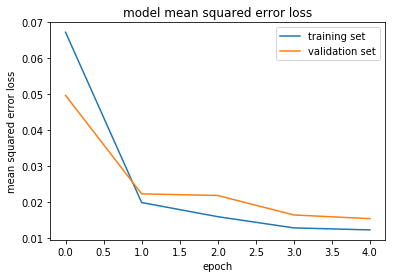

In [12]:
from keras.models import Model
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [14]:
accuracy = model.evaluate_generator(generator=test_generator, steps=len(test_samples)/ batch_size)
print('Test accuracy: ', accuracy)

Test accuracy:  [0.014720664625208617, 0.98819845845933596]


### Loading the model weights before using it to predict the search windows

In [16]:
model = generate_model(input_shape = image_interest)
model.load_weights('model.h5')

# save the architecture of the model as json
json_string = model.to_json()
print(json_string)
with open('model.json', 'w') as file:
    file.write(json_string)

{"config": [{"config": {"output_shape": [300, 1280, 3], "trainable": true, "name": "lambda_6", "output_shape_type": "raw", "arguments": {}, "dtype": "float32", "function_type": "lambda", "function": ["\u00e3\u0001\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0001\u0000\u0000\u0000\u0002\u0000\u0000\u0000S\u0000\u0000\u0000s\b\u0000\u0000\u0000|\u0000\u0000d\u0001\u0000\u001bS)\u0002N\u00e7\u0000\u0000\u0000\u0000\u0000\u00e0o@\u00a9\u0000)\u0001\u00da\u0001xr\u0002\u0000\u0000\u0000r\u0002\u0000\u0000\u0000\u00fa\u001e<ipython-input-4-f33f89634d27>\u00da\b<lambda>\t\u0000\u0000\u0000s\u0000\u0000\u0000\u0000", null, null], "batch_input_shape": [null, 300, 1280, 3]}, "class_name": "Lambda"}, {"config": {"kernel_regularizer": null, "trainable": true, "name": "conv2d_21", "filters": 16, "kernel_initializer": {"config": {"scale": 1.0, "seed": null, "distribution": "uniform", "mode": "fan_avg"}, "class_name": "VarianceScaling"}, "use_bias": true, "activity_regularizer": null, "activation": "r

In [3]:
img_input_shape=(720, 1280, 3)
height_of_interest = (400, 700)
image_interest = (height_of_interest[1] - height_of_interest[0], img_input_shape[1], img_input_shape[2])
print("Region of interest for image frame:", image_interest)
print("Sample image shape:", (64, 64))
model = generate_model(input_shape = image_interest)
model.load_weights('model.h5')

Region of interest for image frame: (300, 1280, 3)
Sample image shape: (64, 64)


In [16]:
%matplotlib inline
def search_windows(img):

    confidence_thresh = .5
    win_size = 64
    boxes = []
        
    # cutting the region of interest only
    img_region = img[height_of_interest[0]:height_of_interest[1], :]
    img_region = np.expand_dims(img_region, axis=0)

    # 1. running model prediction on the region of interest
    # 2. convert the result to 2 dimentions (the model insist of 4 dimentions)
    # 3. using threshold of 0.5 on the results to get boolean classification results 
    model_detections = model.predict(img_region)
    model_detections = model_detections.reshape(model_detections.shape[1], model_detections.shape[2])
    model_detections = model_detections > confidence_thresh
    
    y_region = img_region.shape[1] / model_detections.shape[0]
    x_region = img_region.shape[2] / model_detections.shape[1]
    labels = label(model_detections, structure=generate_binary_structure(2,2))

    for box in range(labels[1]):

        nz = (labels[0] == box + 1).nonzero()
        nysteps = np.array(nz[0])
        nxsteps = np.array(nz[1])
        y_win_min = np.min(nysteps)
        x_win_min = np.min(nxsteps) - win_size/2
        x_win_max = np.max(nxsteps) + win_size/2
        y_win_max = np.max(nysteps) + win_size
        xspan = x_win_max - x_win_min
        yspan = y_win_max - y_win_min
        
        for x, y in zip(nxsteps, nysteps):

            offsetX = (x - x_win_min) / xspan * win_size
            offsetY = (y - y_win_min) / yspan * win_size
            top_left_X = int(round(x * x_region - offsetX, 0))
            top_left_Y = int(round(y * y_region - offsetY, 0))
            bottom_right_X = top_left_X + win_size
            bottom_right_Y = top_left_Y + win_size
            topLeft = (top_left_X, height_of_interest[0] + top_left_Y)
            bottomRight = (bottom_right_X, height_of_interest[0] + bottom_right_Y)

            boxes.append((topLeft, bottomRight))
            # Designed for display purposes only (notebook pipeline output)
            cv2.rectangle(img, pt1=(topLeft[0], topLeft[1]), pt2=(bottomRight[0], bottomRight[1]), color=(51,46,201), thickness=3)
    
    mask = np.zeros_like(img[:, :, 0]).astype(np.float)
    mask, heatMap = create_heatMap(mask, bBoxes=boxes)
    _,mask = cv2.threshold(mask,5,255,cv2.THRESH_BINARY)
    
    newBoxes = label(mask, structure=generate_binary_structure(2,2))
    save_boxes(newBoxes)

    return heatMap

In [27]:
# Auxiliary functions

# Creating a HeatMap represents the original image, where each pixel gets 
# rating by the number of appearance on the detected boxes.
def create_heatMap(mask, bBoxes):
    #Create the mask with the detected boxes, and then clip values outside the mask to the mask edges
    for box in bBoxes:
        mask[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        mask = np.clip(mask, 0, 255)
        
    heatMapInt = cv2.equalizeHist(mask.astype(np.uint8))
    heatMap = cv2.applyColorMap(heatMapInt, cv2.COLORMAP_JET)
    heatMap = cv2.cvtColor(heatMap, code=cv2.COLOR_BGR2RGB)
    
    mask
    return mask, heatMap

# Adding the current boxes that were found to the list of latest boxes
# saving alwayes the last 30 detected boxes for smoother result
def save_boxes(newBoxes):
    global previous_boxes
    for i in range(newBoxes[1]):
        box = (newBoxes[0] == i + 1).nonzero()
        previous_boxes.append([np.min(np.array(box[1])), np.min(np.array(box[0])), 
                                    np.max(np.array(box[1])), np.max(np.array(box[0]))])
        previous_boxes = previous_boxes[-30:] # will save the latest 30 boxes obly 

# Applying cv2.groupRectangles() on the 'history box-list' to avoid 
# duplication and attach boxes with identical pixel resolution.
def group_regions():
    global previous_boxes
    #boxes, _ = cv2.groupRectangles(rectList=np.array(previous_boxes).tolist(), groupThreshold=0, eps=0)
    boxes, _ = cv2.groupRectangles(rectList=np.array(previous_boxes).tolist(), groupThreshold=10, eps=.1)
    return boxes

# Draw the boxes on the original image using cv2.rectangle() method.
def draw_boxes(img, bBoxes):
    for bBox in bBoxes:
        bBox = np.array(bBox)
        bBox = bBox.reshape(bBox.size)
        cv2.rectangle(img, pt1=(bBox[0], bBox[1]), pt2=(bBox[2], bBox[3]), color=(64,225,101), thickness=4)
        font=cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,'Vehicle',(bBox[0]+10, bBox[1]-5), font, 0.6,(255,255,255),2)
    return img


### Main pipeline
The method receiving an image of 720X1280 and consists of the following steps:

1. Cutting the region of interest from the image. the area were the vehicles can be found is only on the road, so I'm cutting the 'Unnecessary' parts of the image, and using only pixels from 400 to 700 (from the top of the image). The image has 3 channels, so the model input shape will be (300,1280,3).
2. Running the model prediction on the image will return a list of (x,y) predictions. First, I'm using threshold of 0.5 as the confidence threshold on the results to get the boolean classification results, and then I have a loop running on all the detected pixels to order them in a list of boxes.(topLeft, bottomRight).
3. Creating a HeatMap represents the original image, where each pixel gets rating by the number of appearance on the detected boxes.
4. Adding the boxes to a history-list in order to get smother affect for the video stream.
5. Applying cv2.groupRectangles() method on the 'history box-list' to avoid duplication and attach boxes with identical pixel resolution.
6. Draw the boxes on the original image using cv2.rectangle() method.

The methos output is the original image with boxes around the detected cars on the image
For visualization- The methos can also return the HeatMap and the image with ALL the boxes (before the 'reducing' steps)

In [7]:
def detect_vehicles(img, isTesting=False):
    origImg= np.copy(img)
    
    # Search for matches by the model
    heatmap = search_windows(img)

    # group boxes togther to one 
    vBoxes = group_regions()
    
    # The boxes after prediction and heatMap threshold
    detected = draw_boxes(origImg, vBoxes)
    
    if (isTesting): #Include the heatMap for display
        return detected, heatmap, img
    return detected

### Test Images
Running the Pipeline on the test images to get the final output with the detected boxes from the model, along with the heatMap of each image

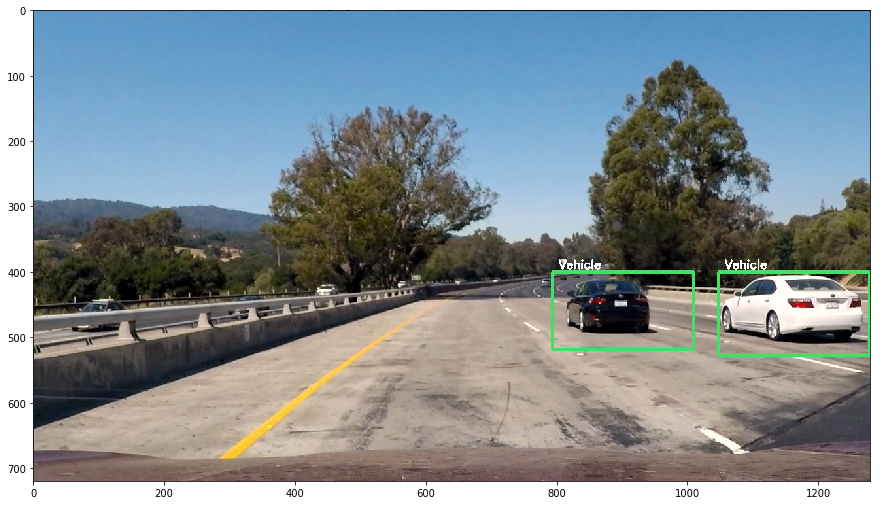

In [36]:
%matplotlib inline
previous_boxes=[]

path = '/home/carnd/vehicle_detection/'
img = mpimg.imread(path + 'test_images/test1.jpg')
output = detect_vehicles(img)
plt.figure(figsize=(15, 12))
plt.imshow(output)

Here are some examples of test images demonstrating the pipeline steps. The right images illustrate the areas detected as vehicles from the model prediction. On the middle of each row we can see the 'HeatMap', presenting how many boxes detected each pixel in the image. On the left we can see the pipeline output with the squares around the vehicles detection.

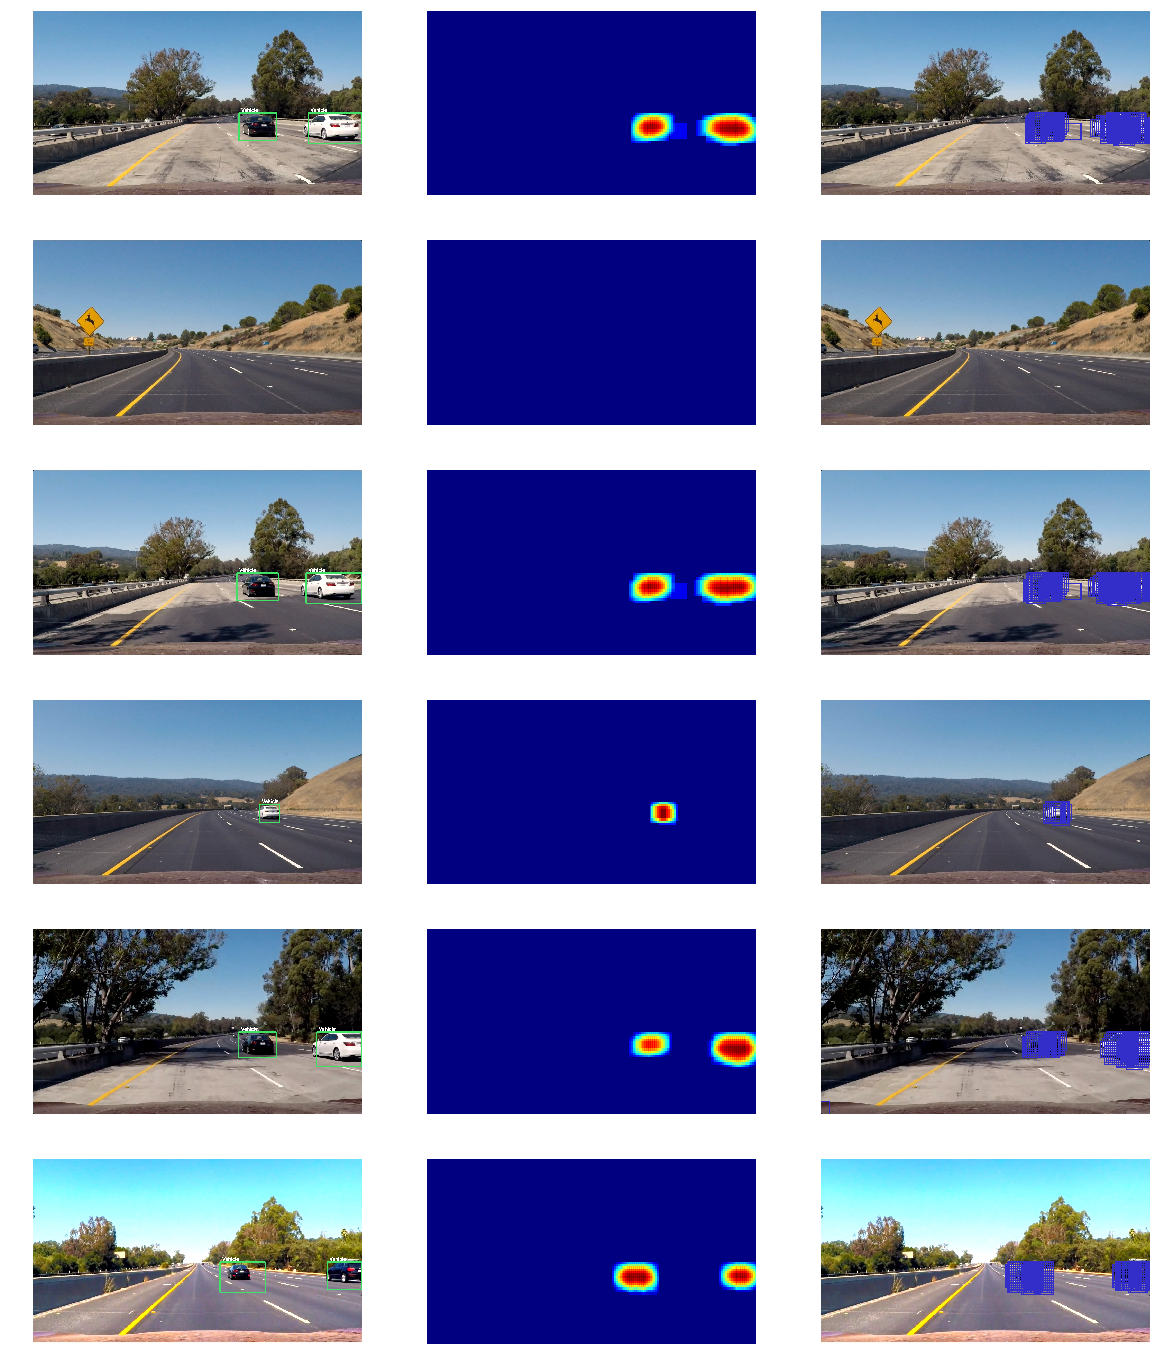

In [159]:
%matplotlib inline

sample_images = []
path = '/home/carnd/vehicle_detection/'
images = glob.glob(path + 'test*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    previous_boxes=[]
    detected, heatmap, ungrouped = detect_vehicles(img, isTesting=True)
    sample_images.append(detected)
    sample_images.append(heatmap)
    sample_images.append(ungrouped)
    
plt.figure(figsize=(20, 50))
for i in range(len(sample_images)):
    plt.subplot(12, 3, i+1)
    plt.imshow(sample_images[i]) 
    plt.axis('off')

### Test on Videos
I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then used cv2.threshold() to identify vehicle positions. I then used scipy.ndimage.measurements.label() which outlining the boundaries of labels to identify individual blobs in the heatmap, where I assumed each blob corresponded to a vehicle in the image. I used an array called previous_boxes, where for each video frame - I'm calling the 'save_boxes' method to update the boxes array with the new model predictions, saving alwayes the last 30 detected boxes for smoother result. I used cv2.groupRectangles in the 'group_regions()' method to construct bounding boxes which cover the area of each blob detected.

In [42]:
# Test the pipeline for videos
from moviepy.editor import VideoFileClip

previous_boxes=[]
path = '/home/carnd/vehicle_detection/test_video/'
white_output = (path + 'test_video_output.mp4')
clip1 = VideoFileClip(path + 'test_video.mp4')
white_clip = clip1.fl_image(detect_vehicles)#.subclip(6,10)
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video /home/carnd/vehicle_detection/test_video/test_video_output.mp4
[MoviePy] Writing video /home/carnd/vehicle_detection/test_video/test_video_output.mp4


 97%|█████████▋| 38/39 [00:21<00:00,  1.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/carnd/vehicle_detection/test_video/test_video_output.mp4 

CPU times: user 1min 34s, sys: 8.47 s, total: 1min 43s
Wall time: 22.9 s


In [44]:
# Main project_video output
from moviepy.editor import VideoFileClip

previous_boxes=[]
path = '/home/carnd/vehicle_detection/test_video/'
white_output = (path + 'project_video_output.mp4')
clip1 = VideoFileClip(path + 'project_video.mp4')
white_clip = clip1.fl_image(detect_vehicles)#.subclip(1,8)
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video /home/carnd/vehicle_detection/test_video/project_video_output.mp4
[MoviePy] Writing video /home/carnd/vehicle_detection/test_video/project_video_output.mp4


100%|█████████▉| 1260/1261 [10:22<00:00,  1.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/carnd/vehicle_detection/test_video/project_video_output.mp4 

CPU times: user 50min 3s, sys: 4min 37s, total: 54min 41s
Wall time: 10min 23s
